# National Energy Consortium (NEC)

## Problem Statement
- **Objective**: Select one plant form 64 options to serve each demand scenario
- **Goal**: Minimise cost (UDS/MWh) for meeting demand
- **Error Metrics**: RMSE between optimal and selected plant costs
- **Data**: 3 Datasets (demand, plants, generations_costs)

### Error metric

The per-scenario error is defined as:

$$
\text{Error}(d) \;=\; \min_{p \in P} c(p, d) \;-\; c(p'_d, d)
$$

- d: a demand scenario  
- P: set of candidate plants (64 options)  
- p: a plant in P  
- p'_d: the plant selected for scenario d by the model/heuristic  
- c(p, d): cost (UDS/MWh) of plant p under scenario d

Notes:
- This computes the difference between the optimal (minimum) cost across all plants for scenario d and the cost of the selected plant.  
- Use these per-scenario errors to compute aggregate metrics (e.g., RMSE, MAE) across all scenarios.

### Score (RMSE)

The aggregate error score (root-mean-square error) across demand scenarios is:

$$
\text{Score} \;=\; \sqrt{\frac{1}{D}\sum_{d=1}^{D}\text{Error}(d)^2}
$$

Where:
- D: total number of demand scenarios  
- Error(d): per-scenario error (as defined earlier, Error(d) = min_{p in P} c(p,d) - c(p'_d,d))

This score summarizes the typical magnitude of the per-scenario selection error (lower is better).

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import json
import warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Any
import os

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


#### Helper classes and Data Structure

In [2]:
class Logger:
    def __init__(self, verbose: bool = True):
        self.verbose = verbose
    
    def header(self, text:str, width:int=80):
        if self.verbose:
            print("="*width)
            print(text)
            print("="*width)
    
    def subheader(self,text:str):
        if self.verbose:
            print(f"\n{text}")
            print("-"*len(text))
            
    def info(self, text:str, indent:int=0):
        if self.verbose:
            print(" "*indent + f"✔ {text}")
    
    def data(self, text:str, indent: int=0):
        if self.verbose:
            print(" "*indent + f"➤ {text}")
    
    def metric(self, label:str, value: Any, unit:str="", indent:int=0):
        if self.verbose:
            print(" "*indent +f" {label}: {value} {unit}")
        
    def success(self, text:str):
        if self.verbose:
            print(f"\n{'='*80}")
            print(f"✔ {text}")
            print(f"{'='*80}\n")
        

        
@dataclass
class StepConfig:
    name: str
    description: str
    verbose: bool = True

class Step:
    def __init__(self, config:Optional[StepConfig]=None):
        self.config = config or StepConfig("Step","Generic Step")
        self.logger = Logger(verbose=self.config.verbose) 

    def execute(self, *args, **kwargs):
        raise NotImplementedError("Execute method must be implemented by subclasses")
    
    def get_results(self) -> Dict[str, Any]:
        raise NotImplementedError("get_results method must be implemented by subclasses")


class DataValidator:
    """Validates data quality and properties"""
    
    @staticmethod
    def check_missing_values(df: pd.DataFrame, columns: List[str]) -> Dict[str, int]:
        """Check missing values in specific columns"""
        return {col: df[col].isnull().sum() for col in columns}
    
    @staticmethod
    def get_missing_stats(df: pd.DataFrame, columns: List[str]) -> Dict[str, Any]:
        """Get comprehensive missing value statistics"""
        total = len(df)
        missing = df[columns].isnull().sum().sum()
        missing_pct = 100 * missing / (len(columns) * total) if total > 0 else 0
        
        # Calculate mean/std only on numeric columns
        numeric_cols = [col for col in columns if pd.api.types.is_numeric_dtype(df[col])]
        sample_mean = df[numeric_cols].values.mean() if numeric_cols else 0
        sample_std = df[numeric_cols].values.std() if numeric_cols else 0
        
        return {
            'total_records': total,
            'missing_count': missing,
            'missing_percent': missing_pct,
            'feature_count': len(columns),
            'sample_mean': sample_mean,
            'sample_std': sample_std
        }
    
    @staticmethod
    def validate_features(df: pd.DataFrame, prefix: str) -> List[str]:
        """Extract and validate features with given prefix"""
        features = [col for col in df.columns if col.startswith(prefix) and pd.api.types.is_numeric_dtype(df[col])]
        return features

class FeatureScaler:
    """Wrapper for feature scaling operations"""
    
    def __init__(self):
        self.scaler_demand = None
        self.scaler_plant = None
    
    def fit_transform(self, demand_df: pd.DataFrame, plant_df: pd.DataFrame,
                      demand_features: List[str], plant_features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Fit scalers and transform data"""
        self.scaler_demand = StandardScaler()
        self.scaler_plant = StandardScaler()
        
        demand_df_scaled = demand_df.copy()
        plant_df_scaled = plant_df.copy()
        
        demand_df_scaled[demand_features] = self.scaler_demand.fit_transform(demand_df[demand_features])
        plant_df_scaled[plant_features] = self.scaler_plant.fit_transform(plant_df[plant_features])
        
        return demand_df_scaled, plant_df_scaled
    
    def get_scalers(self) -> Tuple[Optional[StandardScaler], Optional[StandardScaler]]:
        """Return fitted scalers (may be None if not yet fitted)"""
        return self.scaler_demand, self.scaler_plant

class PlantSelector:
    """Identifies and removes worst-performing plants"""
    
    def __init__(self, threshold_percentile: float = 75):
        self.threshold_percentile = threshold_percentile
        self.threshold_cost = None
        self.good_plants = []
        self.worst_plants = []
    
    def analyze_plants(self, costs_df: pd.DataFrame) -> Dict[str, Any]:
        """Analyze plant performance"""
        plant_stats = costs_df.groupby('Plant ID')['Cost_USD_per_MWh'].agg(
            ['median', 'mean', 'count']
        ).sort_values('median')
        
        self.threshold_cost = plant_stats['median'].quantile(self.threshold_percentile / 100)
        self.worst_plants = plant_stats[plant_stats['median'] > self.threshold_cost].index.tolist()
        self.good_plants = plant_stats[plant_stats['median'] <= self.threshold_cost].index.tolist()
        
        return {
            'stats': plant_stats,
            'threshold': self.threshold_cost,
            'good_plants': self.good_plants,
            'worst_plants': self.worst_plants
        }
    
    def filter_data(self, demand_df: pd.DataFrame, plants_df: pd.DataFrame, 
                   costs_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Filter datasets based on plant selection"""
        plants_filtered = plants_df[plants_df['Plant ID'].isin(self.good_plants)].reset_index(drop=True)
        costs_filtered = costs_df[
            (costs_df['Demand ID'].isin(demand_df['Demand ID'])) &
            (costs_df['Plant ID'].isin(self.good_plants))
        ].reset_index(drop=True)
        
        return demand_df, plants_filtered, costs_filtered

class ErrorCalculator:
    """Calculates custom error metrics"""
    
    @staticmethod
    def calculate_plant_selection_error(model, X_test: np.ndarray, test_demands_set: set,
                                       combined_df_test: pd.DataFrame, demand_features: List[str],
                                       plant_features: List[str]) -> np.ndarray:
        """Calculate error using Equation 1: Error(d) = c(p_model, d) - min{c(p,d)}
        
        The model predicts costs for each plant given demand+plant features.
        We select the plant with the lowest predicted cost, then calculate the error
        as the difference between the actual cost of our selected plant and the oracle cost
        (the minimum actual cost across all plants for that demand).
        
        Positive error means we selected a plant worse than the oracle.
        """
        errors = []
        feature_cols = demand_features + plant_features
        
        for demand_id in test_demands_set:
            demand_test_costs = combined_df_test[combined_df_test['Demand ID'] == demand_id].copy()
            
            if len(demand_test_costs) == 0:
                continue
            
            # Oracle: minimum actual cost across all plants for this demand
            actual_costs = demand_test_costs['Cost_USD_per_MWh'].values
            min_actual_cost = actual_costs.min()
            
            # Model prediction: predict cost for each plant given its features
            X_demand = demand_test_costs[feature_cols].values
            predicted_costs = model.predict(X_demand)
            
            # Select plant with lowest predicted cost
            selected_idx = np.argmin(predicted_costs)
            
            # Get the actual cost of the selected plant (not predicted cost)
            selected_actual_cost = actual_costs[selected_idx]
            
            # Error: how much more we paid compared to oracle
            # Positive when we overpay vs oracle
            error = selected_actual_cost - min_actual_cost
            errors.append(error)
        
        return np.array(errors)
    
    @staticmethod
    def calculate_rmse(errors: np.ndarray) -> float:
        """Calculate RMSE from errors (Equation 2)"""
        return np.sqrt(np.mean(errors ** 2))
    
    @staticmethod
    def get_error_statistics(errors: np.ndarray) -> Dict[str, float]:
        """Get comprehensive error statistics (returns Python floats)"""
        # Handle empty input gracefully
        if errors.size == 0:
            return {
                'mean': 0.0,
                'median': 0.0,
                'std': 0.0,
                'min': 0.0,
                'max': 0.0,
                'rmse': 0.0
            }
        return {
            'mean': float(errors.mean()),
            'median': float(np.median(errors)),
            'std': float(errors.std()),
            'min': float(errors.min()),
            'max': float(errors.max()),
            'rmse': float(np.sqrt(np.mean(errors ** 2)))
        }
        

        

## Data Preparation
In the data preparation stage, please adopt a comprehensive approach, addressing the following areas:
1. **Handle any missing data** by identifying and managing incomplete records or missing values to ensure the dataset is ready for further analysis.
2. **Perform relevant feature selection** by determining which features are most important for your goal. Additionally, apply feature scaling to normalise the data and ensure all featues contribute equally to the model, avoiding biases due to deffering ranges.
3. **Focus on identifying the top-performing plants** for each demand by analysing the cost data. Since not all plants perform equally well, you should remove the worst-performing plants from the dataset to make the following tasks more manageable.

In [3]:
class DataPreparation(Step):
    def __init__(self, config:Optional[StepConfig]=None):
        super().__init__(config or StepConfig("Step 1", "Data Preparation"))
        
        self.validator = DataValidator()
        self.scaler = FeatureScaler()
        self.plant_selector = PlantSelector()
        
        ## Results storage
        self.demand_df_clean = None
        self.plants_df_filtered = None
        self.costs_df_filtered = None
        self.demand_features = None
        self.plant_features = None
        self.metadata = {}
        
    
    
    def _print_summary(self):
        def _safe_len(obj):
            return len(obj) if obj is not None else 0

        print("Data Preparation Summary:")
        print(f"  - Demand scenarios: {_safe_len(self.demand_df_clean)}")
        print(f"  - Plants: {_safe_len(self.plants_df_filtered)}")
        print(f"  - Cost records: {_safe_len(self.costs_df_filtered)}")
        print(f"  - Demand features: {_safe_len(self.demand_features)}")
        print(f"  - Plant features: {_safe_len(self.plant_features)}")
    
    def get_results(self) -> Dict[str, Any]:
        return {
            "demand_df": self.demand_df_clean,
            "plants_df": self.plants_df_filtered,
            "costs_df": self.costs_df_filtered,
            "demand_features": self.demand_features,
            "plant_features": self.plant_features,
            "metadata": self.metadata
        }
            
    def execute(self, demand_path:str, plants_path:str, costs_path:str):
        
        ## Load data
        demand_df = pd.read_csv(demand_path, keep_default_na=False, na_values=[""])
        plants_df = pd.read_csv(plants_path, keep_default_na=False, na_values=[""])
        costs_df = pd.read_csv(costs_path, keep_default_na=False, na_values=[""])
        
        ## Handle missing values
        demand_feature_cols = self.validator.validate_features(demand_df, "DF")
        self.demand_features = demand_feature_cols
        
        missing_stats = self.validator.get_missing_stats(demand_df, demand_feature_cols)
        
        demand_df_clean = demand_df.copy()
        demand_df_clean[demand_feature_cols] = demand_df_clean[demand_feature_cols].fillna(demand_df_clean[demand_feature_cols].mean())
        
        ## Feature scaling
        plant_feature_cols = self.validator.validate_features(plants_df, "PF")
        self.plant_features = plant_feature_cols
        
        demand_df_scaled, plants_df_scaled = self.scaler.fit_transform(demand_df_clean, plants_df, self.demand_features, self.plant_features)
        
        
        ## Remove worst performing plants
        plant_analysis = self.plant_selector.analyze_plants(costs_df)
        
        demand_df_final, plant_df_filtered, costs_df_filtered = self.plant_selector.filter_data(demand_df_scaled, plants_df_scaled, costs_df)
        
        ## Store results
        self.demand_df_clean = demand_df_final
        self.plants_df_filtered = plant_df_filtered
        self.costs_df_filtered = costs_df_filtered
        
        ## remove NaN cost values
        nan_costs = self.costs_df_filtered["Cost_USD_per_MWh"].isna().sum()
        if nan_costs > 0:
            self.costs_df_filtered = self.costs_df_filtered.dropna(subset=["Cost_USD_per_MWh"])
        
        ## Store metadata
        self.metadata = {
            "demand_features": self.demand_features,
            "plant_features": self.plant_features,
            "missing_stats": missing_stats,
            "plant_analysis": plant_analysis
        }
        
        ## Print summary
        self._print_summary()


In [4]:
step_one = DataPreparation()
step_one.execute(
    demand_path="Data/raw/demand.csv",
    plants_path="Data/raw/plants.csv",
    costs_path="Data/raw/generation_costs.csv"
)
step_one_results = step_one.get_results()

Data Preparation Summary:
  - Demand scenarios: 500
  - Plants: 48
  - Cost records: 23927
  - Demand features: 12
  - Plant features: 18


## Exploratory Data Analysis (EDA)
Consider using various EDA techniques to explore the distribution of feature values, cost data and plant performance;
1. Use EDA methods to analyse the distribution of demand features and interpret emerging patterns, such as identifying correlations, clusters, or outliers in demand characteristics
2. Analyse the cost data to identify patterns and good combinations of demand scenarios and plants, such as investigating whether specific plant types or regions are more cost-effective under certain demand contexts.
3. Explore how errors (Eq 1) are distributed across deifferent choices of plants, identifying key trends or outliers in their performance. Calculate the RMSE (Eq 2) of each plant for all scenarios and use them to motivate the need for ML models.

In [5]:
class ExploratoryAnalysis(Step):
    def __init__(self, config:Optional[StepConfig]=None):
        super().__init__(config or StepConfig("Step 2", "Exploratory Data Analysis"))
        self.error_clc = ErrorCalculator()
        
        self.demand_df = None
        self.plants_df = None
        self.costs_df = None
        self.demand_features = None
        self.plant_features = None
        
        self.correlation_insights = {}
    
    def execute(self, results_step_one:Dict[str,Any]):
        
        os.makedirs("Data/plots", exist_ok=True)
        
        self.demand_df = results_step_one["demand_df"]
        self.plants_df = results_step_one["plants_df"]
        self.costs_df = results_step_one["costs_df"]
        self.demand_features = results_step_one["demand_features"]
        self.plant_features = results_step_one["plant_features"]
        
        merged_df = self.costs_df.copy()
        merged_df = merged_df.merge(self.demand_df[["Demand ID"] + self.demand_features], on="Demand ID", how="left")
        merged_df = merged_df.merge(self.plants_df[["Plant ID"] + self.plant_features], on="Plant ID", how="left")
        
        # ============================================================================
        # 1. DEMAND FEATURES DISTRIBUTION
        # ============================================================================
        fig, axes = plt.subplots(3, 4, figsize=(16, 10))
        fig.suptitle("Distribution of Demand features (DF1-DF12)", fontsize=12, fontweight='bold')
        
        for idx, col in enumerate(self.demand_features):
            ax = axes[idx//4, idx%4]
            self.demand_df[col].hist(bins=30, ax=ax, edgecolor="black", alpha=0.7)
            ax.set_title(col, fontweight='bold')
            ax.set_xlabel("Value")
            ax.set_ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 1B. PLANT FEATURES DISTRIBUTION
        # ============================================================================
        fig, axes = plt.subplots(3, 6, figsize=(18, 10))
        fig.suptitle("Distribution of Plant features (PF1-PF18)", fontsize=12, fontweight='bold')
        
        for idx, col in enumerate(self.plant_features):
            ax = axes[idx//6, idx%6]
            self.plants_df[col].hist(bins=30, ax=ax, edgecolor="black", alpha=0.7, color='steelblue')
            ax.set_title(col, fontweight='bold')
            ax.set_xlabel("Value")
            ax.set_ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 2. DEMAND-PLANT FEATURE CORRELATION
        # ============================================================================
        combined_df = pd.concat([self.demand_df[self.demand_features], self.plants_df[self.plant_features]], axis=1)
        corr_cross = combined_df[self.demand_features + self.plant_features].corr()
        cross_corr_matrix = corr_cross.loc[self.demand_features, self.plant_features]
        
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(cross_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax, cbar_kws={"label": "Correlation"})
        ax.set_title("Demand Features vs Plant Features Correlation", fontweight='bold', fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 3. COST DATA ANALYSIS
        # ============================================================================
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        costs_summary = self.costs_df.groupby("Plant ID")["Cost_USD_per_MWh"].agg(["median", "mean", "count"]).sort_values("median")
        axes[0].bar(range(len(costs_summary)), costs_summary["median"], alpha=0.7, edgecolor="black")
        axes[0].set_title("Median Cost by Plant (Sorted)", fontweight="bold")
        axes[0].set_xlabel("Plant Index")
        axes[0].set_ylabel("Cost (USD/MWh)")
        axes[0].grid(axis="y", alpha=0.3)
        
        axes[1].hist(self.costs_df["Cost_USD_per_MWh"], bins=50, edgecolor="black", alpha=0.7, color="orange")
        axes[1].set_title("Distribution of Generation Costs", fontweight="bold")
        axes[1].set_xlabel("Cost (USD/MWh)")
        axes[1].set_ylabel("Frequency")
        mean_cost = self.costs_df["Cost_USD_per_MWh"].mean()
        axes[1].axvline(mean_cost, color="red", linestyle="--", label=f"Mean: ${mean_cost:.2f}")
        axes[1].legend()
        axes[1].grid(axis="y", alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 4. PLANT TYPE AND REGION ANALYSIS
        # ============================================================================
        costs_with_plants = self.costs_df.merge(self.plants_df[['Plant ID', 'Plant Type', 'Region']], on='Plant ID', how='left')
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Cost distribution by Plant Type
        sns.boxplot(data=costs_with_plants, x='Plant Type', y='Cost_USD_per_MWh', ax=axes[0, 0], palette='Set2')
        axes[0, 0].set_title('Cost Distribution by Plant Type', fontweight='bold')
        axes[0, 0].set_ylabel('Cost (USD/MWh)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Cost distribution by Region
        sns.boxplot(data=costs_with_plants, x='Region', y='Cost_USD_per_MWh', ax=axes[0, 1], palette='Set1')
        axes[0, 1].set_title('Cost Distribution by Region', fontweight='bold')
        axes[0, 1].set_ylabel('Cost (USD/MWh)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Average cost by Plant Type
        plant_type_avg = costs_with_plants.groupby('Plant Type')['Cost_USD_per_MWh'].mean().sort_values(ascending=False)
        axes[1, 0].bar(range(len(plant_type_avg)), plant_type_avg.values, color='skyblue', edgecolor='black')
        axes[1, 0].set_xticks(range(len(plant_type_avg)))
        axes[1, 0].set_xticklabels(plant_type_avg.index, rotation=45)
        axes[1, 0].set_title('Average Cost by Plant Type', fontweight='bold')
        axes[1, 0].set_ylabel('Average Cost (USD/MWh)')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        # Average cost by Region
        region_avg = costs_with_plants.groupby('Region')['Cost_USD_per_MWh'].mean().sort_values(ascending=False)
        axes[1, 1].bar(range(len(region_avg)), region_avg.values, color='lightcoral', edgecolor='black')
        axes[1, 1].set_xticks(range(len(region_avg)))
        axes[1, 1].set_xticklabels(region_avg.index, rotation=45)
        axes[1, 1].set_title('Average Cost by Region', fontweight='bold')
        axes[1, 1].set_ylabel('Average Cost (USD/MWh)')
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 5. COST DISTRIBUTION BY PLANT (VIOLIN PLOT)
        # ============================================================================
        fig, ax = plt.subplots(figsize=(16, 6))
        sns.violinplot(data=self.costs_df, x='Plant ID', y='Cost_USD_per_MWh', ax=ax, palette='Set2')
        ax.set_title('Cost Distribution by Plant', fontweight='bold', fontsize=12)
        ax.set_ylabel('Cost (USD/MWh)')
        ax.tick_params(axis='x', rotation=90)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 6. PLANT TYPE AND REGION INTERACTION HEATMAP
        # ============================================================================
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot_type_region = costs_with_plants.pivot_table(values='Cost_USD_per_MWh', index='Plant Type', columns='Region', aggfunc='mean')
        sns.heatmap(pivot_type_region, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, cbar_kws={'label': 'Avg Cost (USD/MWh)'})
        ax.set_title('Average Cost by Plant Type and Region', fontweight='bold', fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # ============================================================================
        # 7. ERROR ANALYSIS: PER-SCENARIO ERRORS AND PLANT RMSE
        # ============================================================================
        
        # Calculate optimal (minimum) cost for each demand scenario
        optimal_costs = self.costs_df.groupby('Demand ID')['Cost_USD_per_MWh'].min()
        
        # For each plant, calculate error for each scenario
        plant_errors = {}
        plant_rmse = {}
        plant_mae = {}
        
        for plant_id in self.costs_df['Plant ID'].unique():
            plant_costs = self.costs_df[self.costs_df['Plant ID'] == plant_id].set_index('Demand ID')['Cost_USD_per_MWh']
            
            # Calculate error: difference between optimal cost and plant's cost
            errors = optimal_costs - plant_costs
            errors = errors.dropna()
            
            if len(errors) > 0:
                plant_errors[plant_id] = errors.values
                plant_rmse[plant_id] = np.sqrt(np.mean(errors.values ** 2))
                plant_mae[plant_id] = np.mean(np.abs(errors.values))
        
        # Create summary dataframe
        plant_performance = pd.DataFrame({
            'Plant ID': list(plant_rmse.keys()),
            'RMSE': list(plant_rmse.values()),
            'MAE': list(plant_mae.values())
        }).sort_values('RMSE')
        
        # Merge with plant info
        plant_performance = plant_performance.merge(
            self.plants_df[['Plant ID', 'Plant Type', 'Region']], 
            on='Plant ID', 
            how='left'
        )
        
        # Store insights
        self.correlation_insights['error_analysis'] = {
            'plant_rmse': plant_rmse,
            'plant_mae': plant_mae,
            'overall_rmse_mean': np.mean(list(plant_rmse.values())),
            'overall_rmse_std': np.std(list(plant_rmse.values())),
            'best_plant_id': plant_performance.iloc[0]['Plant ID'],
            'best_plant_rmse': plant_performance.iloc[0]['RMSE'],
            'worst_plant_id': plant_performance.iloc[-1]['Plant ID'],
            'worst_plant_rmse': plant_performance.iloc[-1]['RMSE']
        }
        
        # Visualization 1: RMSE by Plant (sorted)
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # Top plot: RMSE bar chart (all plants)
        axes[0].bar(range(len(plant_performance)), plant_performance['RMSE'].values, alpha=0.7, edgecolor='black', color='coral')
        axes[0].set_title('Root Mean Square Error (RMSE) by Plant', fontweight='bold', fontsize=12)
        axes[0].set_xlabel('Plant Index (sorted by RMSE)')
        axes[0].set_ylabel('RMSE (USD/MWh)')
        axes[0].axhline(np.mean(list(plant_rmse.values())), color='red', linestyle='--', linewidth=2, label=f'Mean RMSE: ${np.mean(list(plant_rmse.values())):.2f}')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # Bottom plot: Error distribution (top 15 best performing plants)
        top_15_plants = plant_performance.head(15)['Plant ID'].values
        errors_data = [plant_errors[p] for p in top_15_plants]
        bp = axes[1].boxplot(errors_data, labels=[f"P{p}" for p in top_15_plants], patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightgreen')
        axes[1].set_title('Error Distribution for Top 15 Best-Performing Plants', fontweight='bold', fontsize=12)
        axes[1].set_ylabel('Error (USD/MWh)')
        axes[1].grid(axis='y', alpha=0.3)
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Visualization 2: Plant Performance Summary Table
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('tight')
        ax.axis('off')
        
        display_df = plant_performance.head(20)[['Plant ID', 'Plant Type', 'Region', 'RMSE', 'MAE']].copy()
        display_df['RMSE'] = display_df['RMSE'].apply(lambda x: f'${x:.2f}')
        display_df['MAE'] = display_df['MAE'].apply(lambda x: f'${x:.2f}')
        
        # convert DataFrame to list of lists (strings) to satisfy matplotlib.table type requirements
        display_table_data = display_df.astype(str).values.tolist()
        table = ax.table(cellText=display_table_data, colLabels=list(display_df.columns), cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        
        # Color header
        for i in range(len(display_df.columns)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        ax.set_title('Top 20 Best-Performing Plants by RMSE', fontweight='bold', fontsize=12, pad=20)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Visualization 3: RMSE Distribution by Plant Type
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Boxplot: RMSE by Plant Type
        sns.boxplot(data=plant_performance, x='Plant Type', y='RMSE', ax=axes[0], palette='Set2')
        axes[0].set_title('RMSE Distribution by Plant Type', fontweight='bold')
        axes[0].set_ylabel('RMSE (USD/MWh)')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)
        
        # Boxplot: RMSE by Region
        sns.boxplot(data=plant_performance, x='Region', y='RMSE', ax=axes[1], palette='Set1')
        axes[1].set_title('RMSE Distribution by Region', fontweight='bold')
        axes[1].set_ylabel('RMSE (USD/MWh)')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Print summary statistics
        print("\n" + "="*80)
        print("ERROR ANALYSIS SUMMARY")
        print("="*80)
        print(f"Total plants analyzed: {len(plant_rmse)}")
        print(f"Mean RMSE across all plants: ${np.mean(list(plant_rmse.values())):.2f}")
        print(f"Std Dev of RMSE: ${np.std(list(plant_rmse.values())):.2f}")
        print(f"Best performing plant: {plant_performance.iloc[0]['Plant ID']} (RMSE: ${plant_performance.iloc[0]['RMSE']:.2f})")
        print(f"Worst performing plant: {plant_performance.iloc[-1]['Plant ID']} (RMSE: ${plant_performance.iloc[-1]['RMSE']:.2f})")
        print(f"RMSE range: ${plant_performance.iloc[-1]['RMSE'] - plant_performance.iloc[0]['RMSE']:.2f}")
        print("="*80 + "\n")
        
        # Store comprehensive results for downstream use
        self.plant_performance_df = plant_performance
        self.plant_errors_dict = plant_errors
        self.optimal_costs = optimal_costs
        self.baseline_rmse_avg = np.mean(list(plant_rmse.values()))
    
    def get_results(self) -> Dict[str, Any]:
        return {
            "correlation_insights": self.correlation_insights,
            "plant_performance": self.plant_performance_df if hasattr(self, 'plant_performance_df') else None,
            "plant_errors": self.plant_errors_dict if hasattr(self, 'plant_errors_dict') else None,
            "optimal_costs": self.optimal_costs if hasattr(self, 'optimal_costs') else None,
            "baseline_rmse_avg": self.baseline_rmse_avg if hasattr(self, 'baseline_rmse_avg') else None,
            "demand_df": self.demand_df,
            "plants_df": self.plants_df,
            "costs_df": self.costs_df,
            "demand_features": self.demand_features,
            "plant_features": self.plant_features
        }


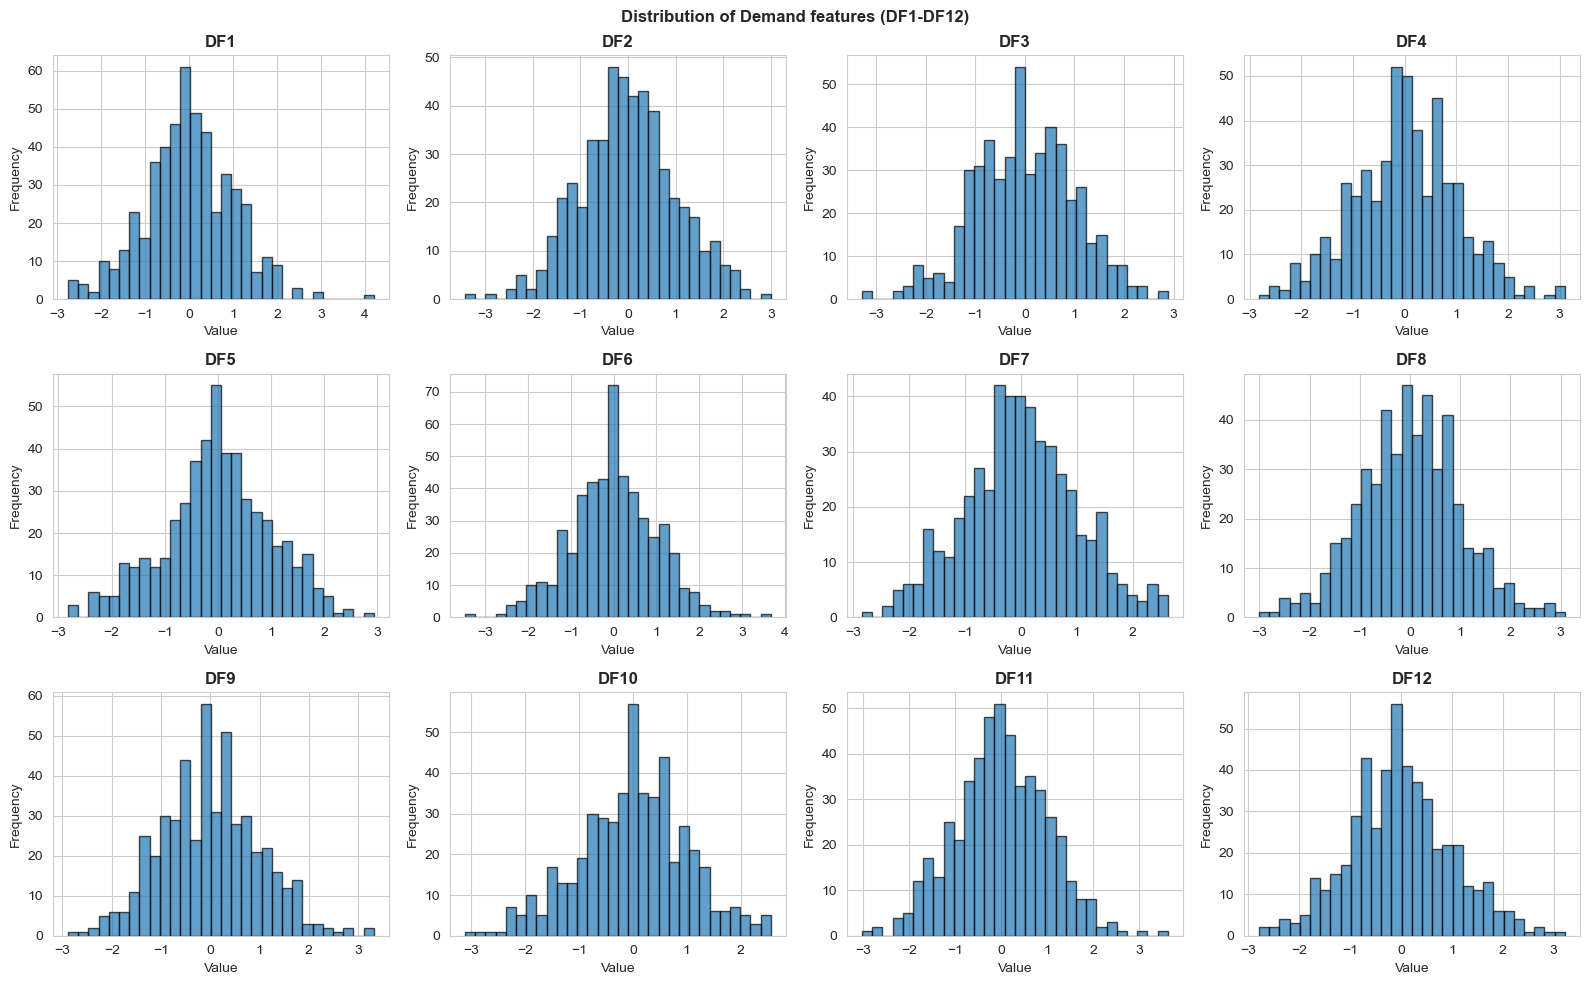

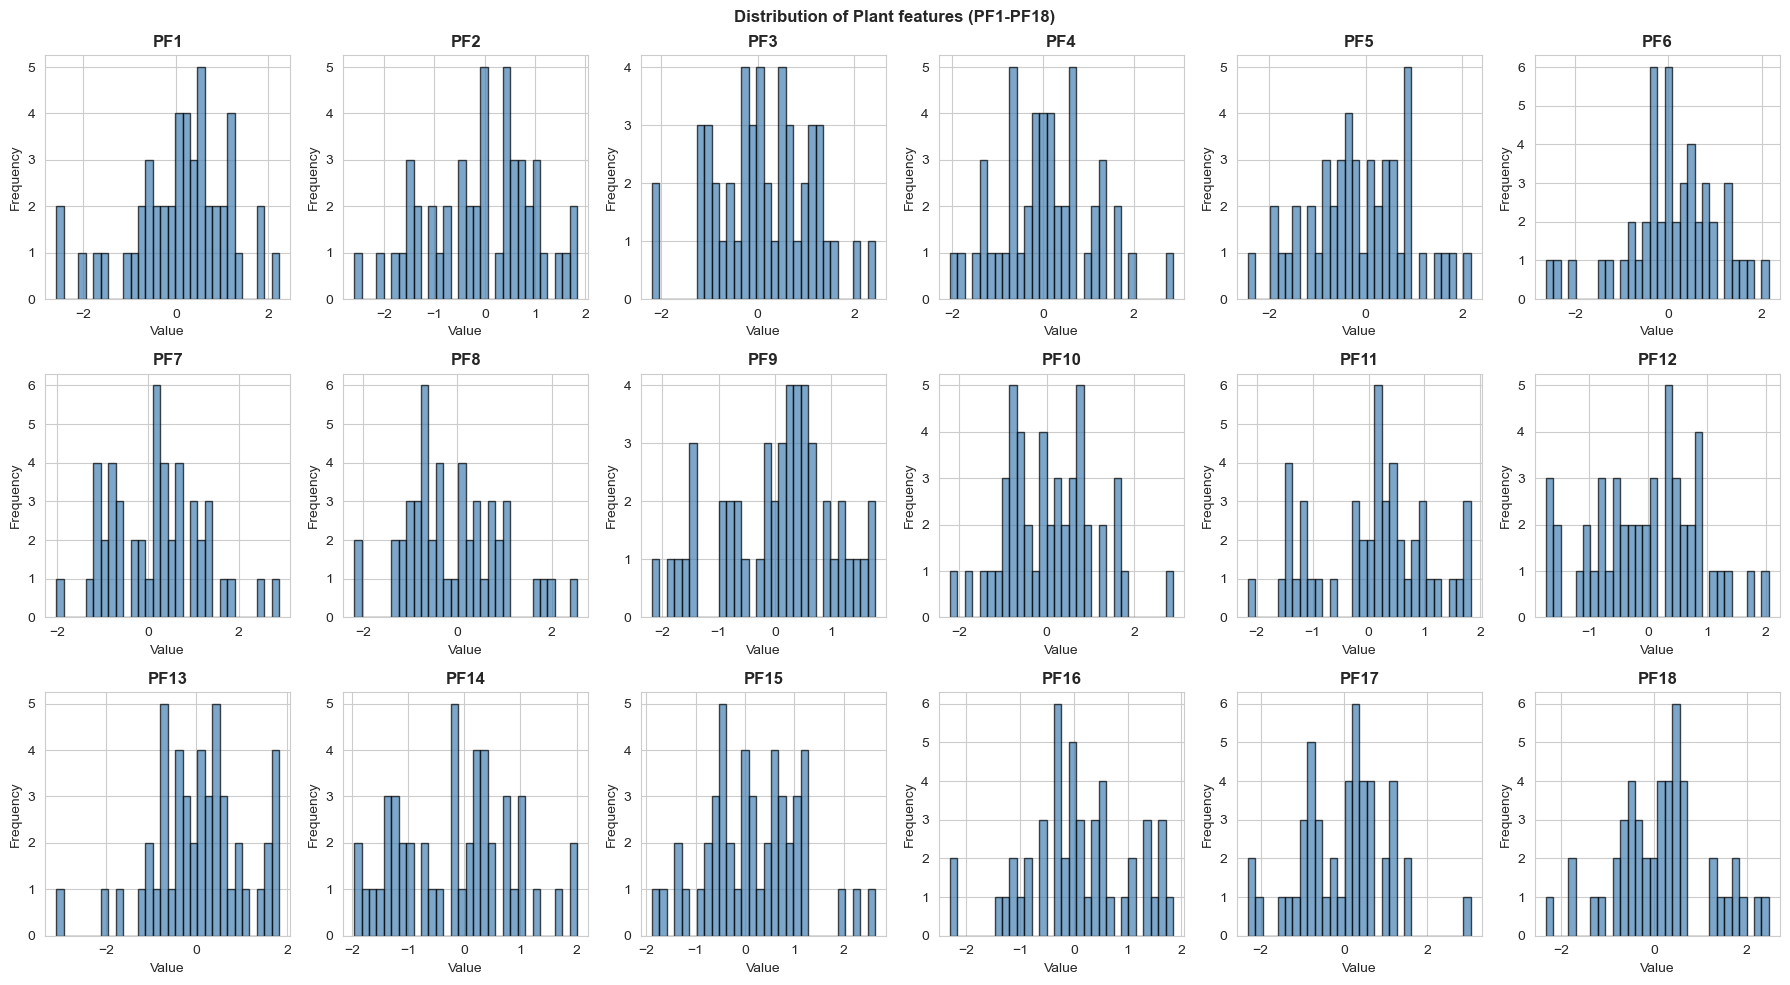

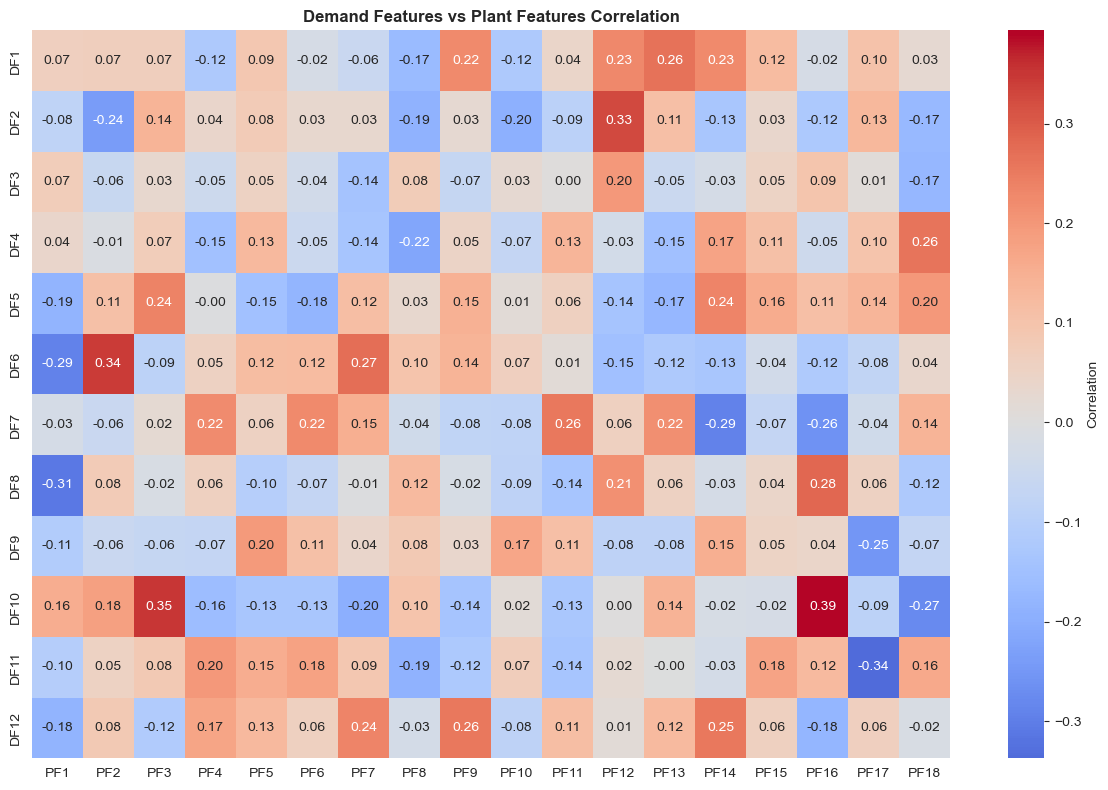

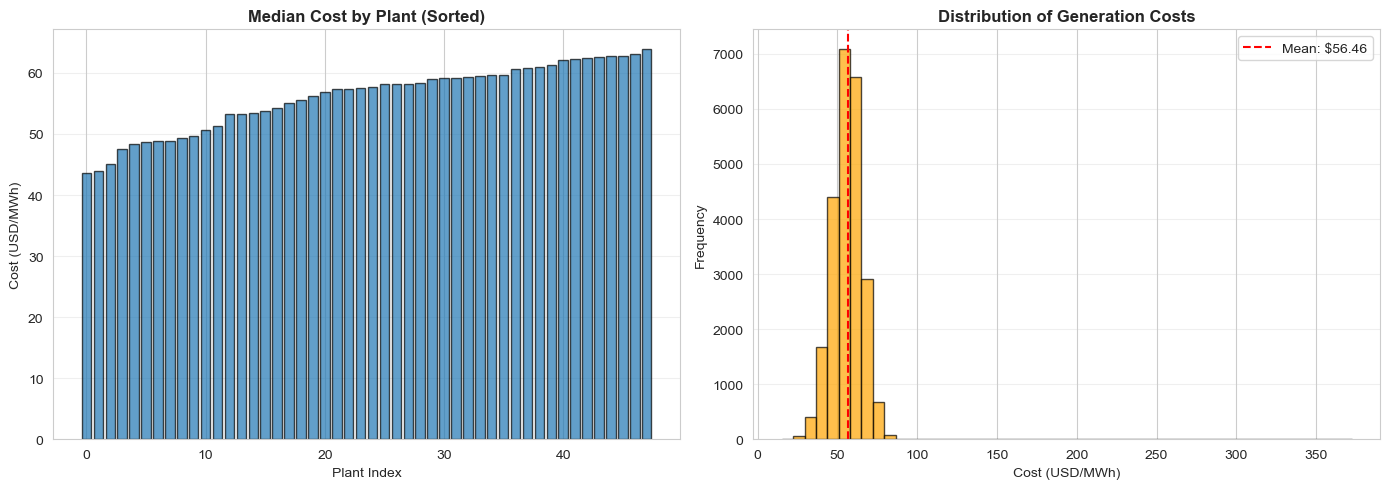

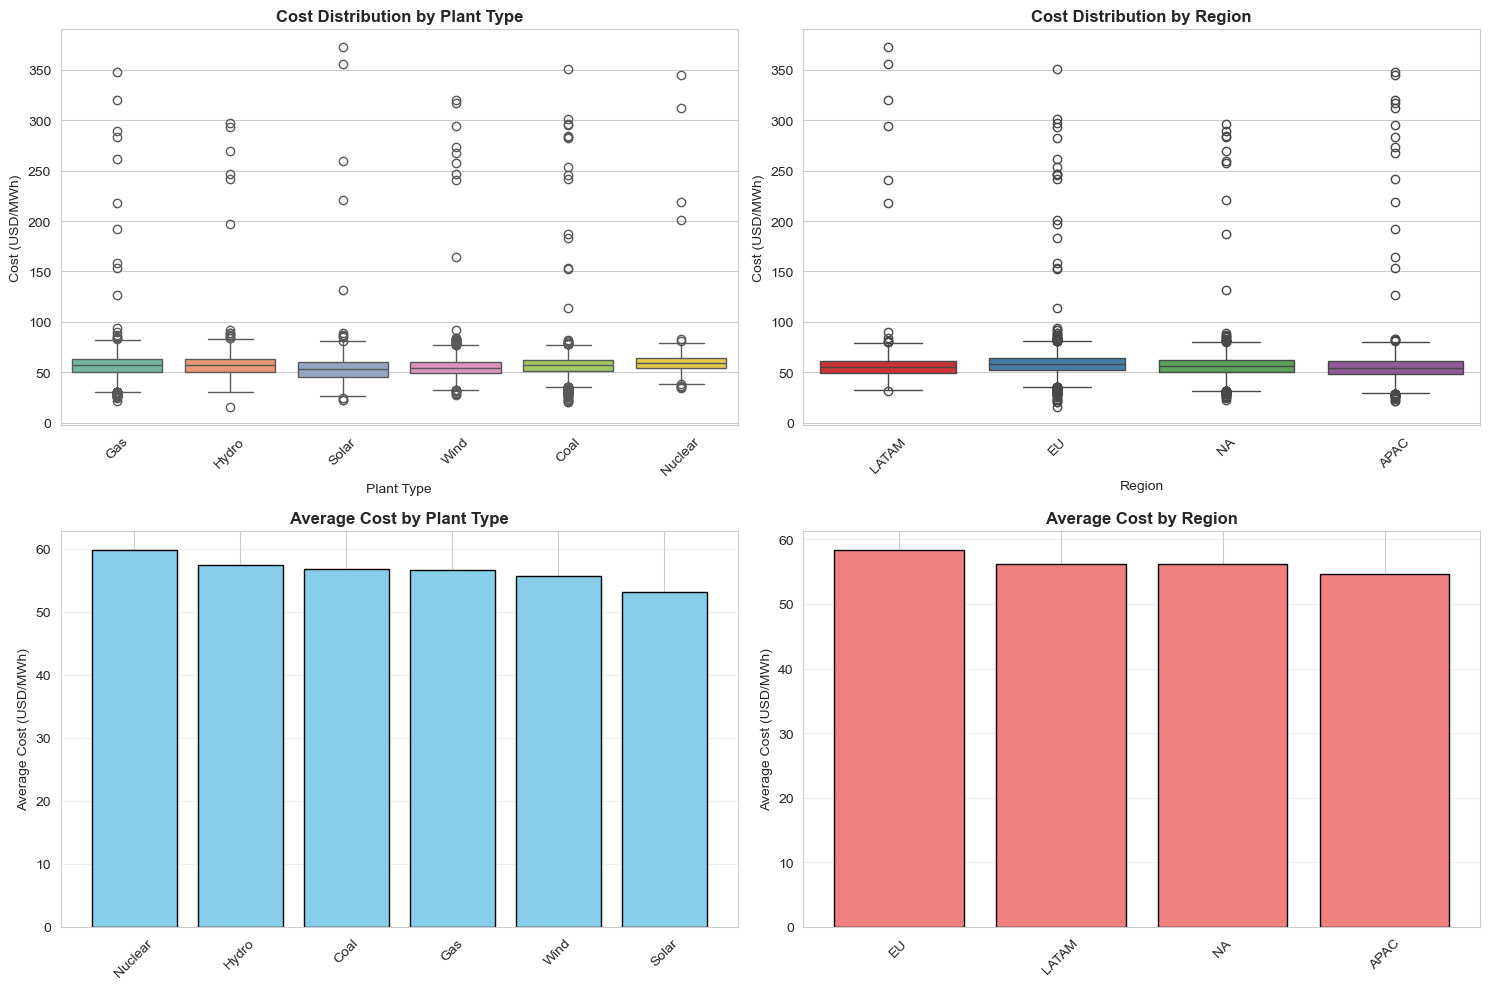

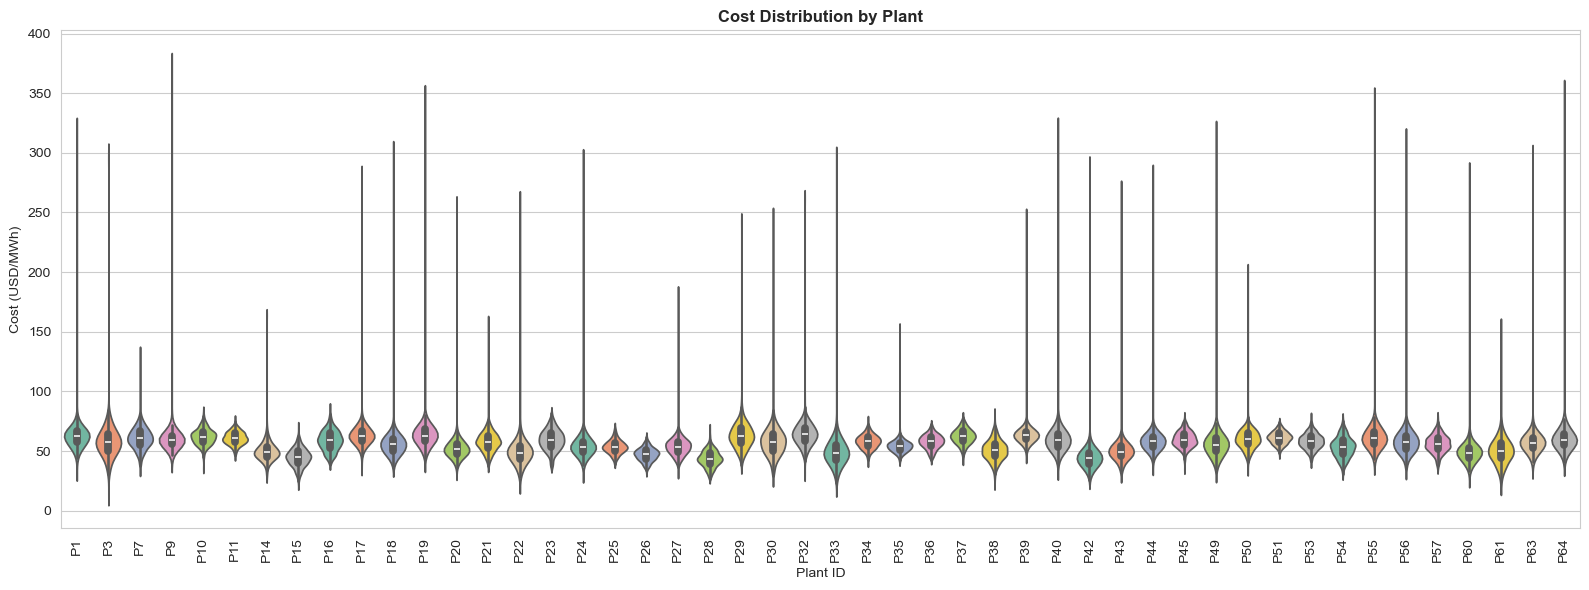

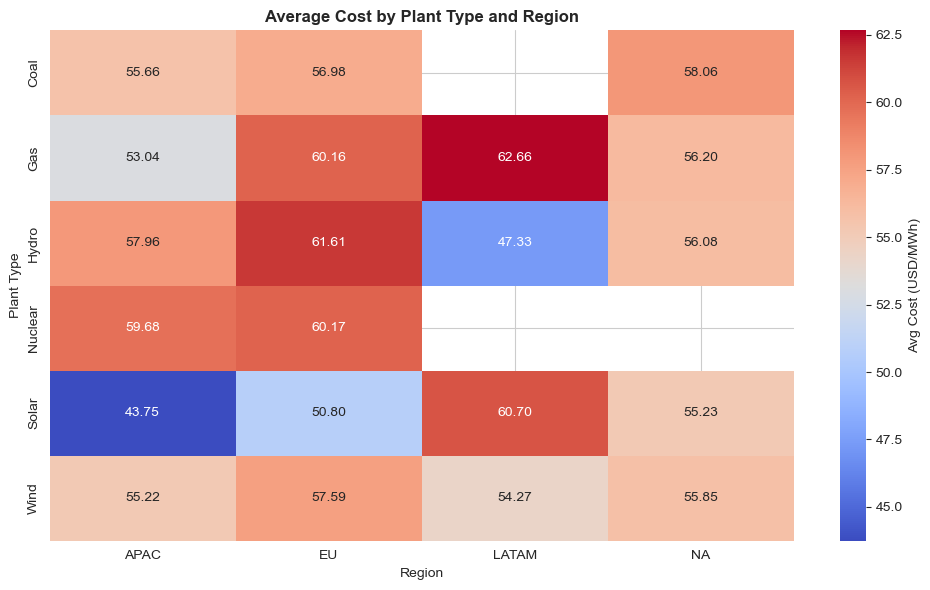

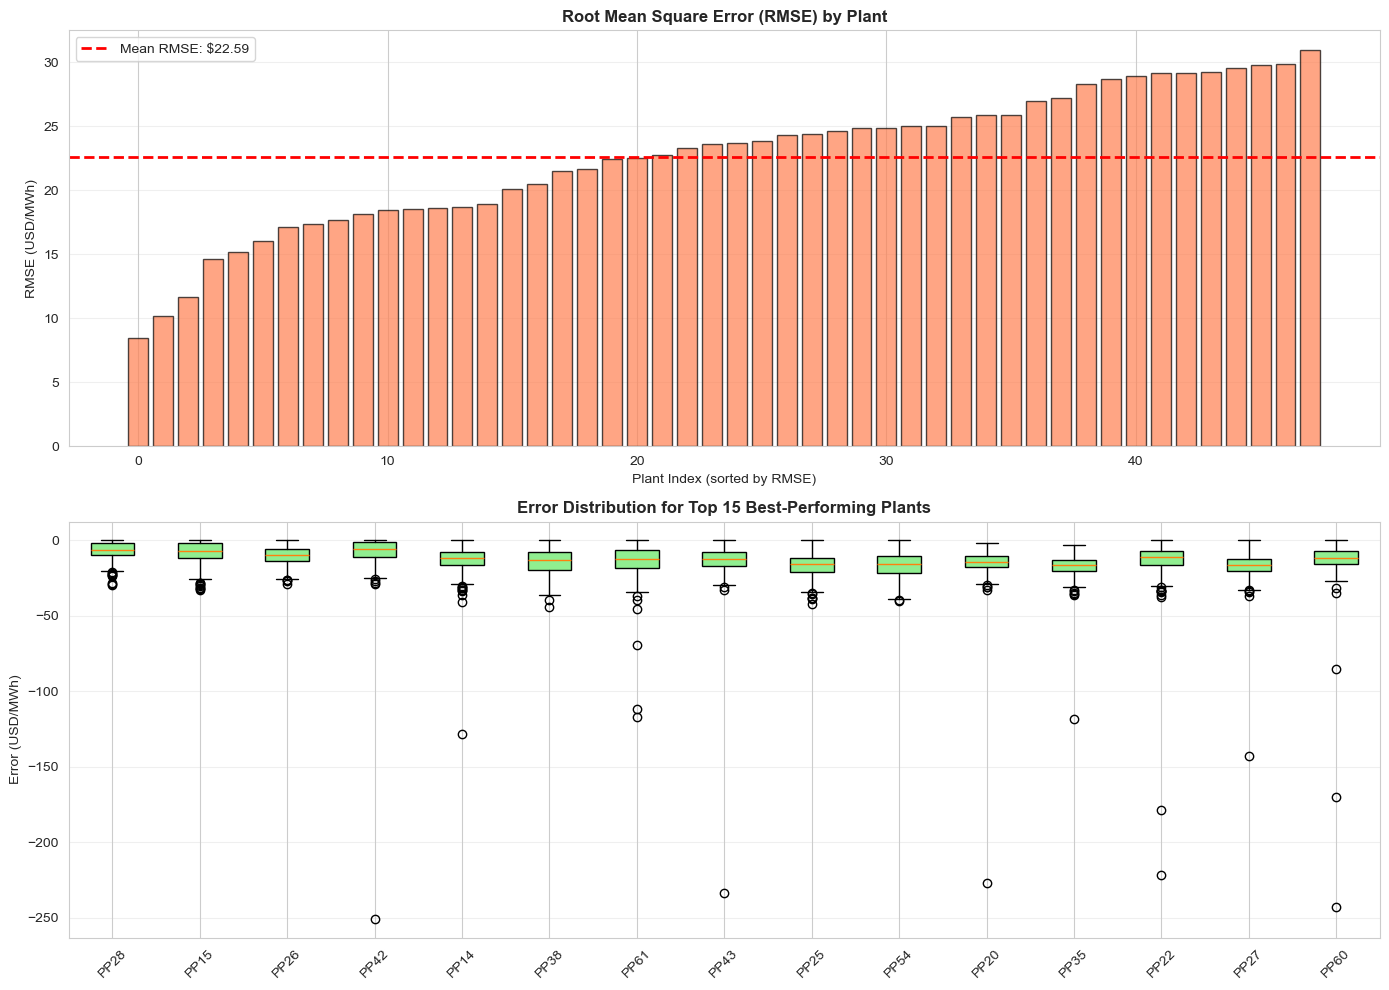

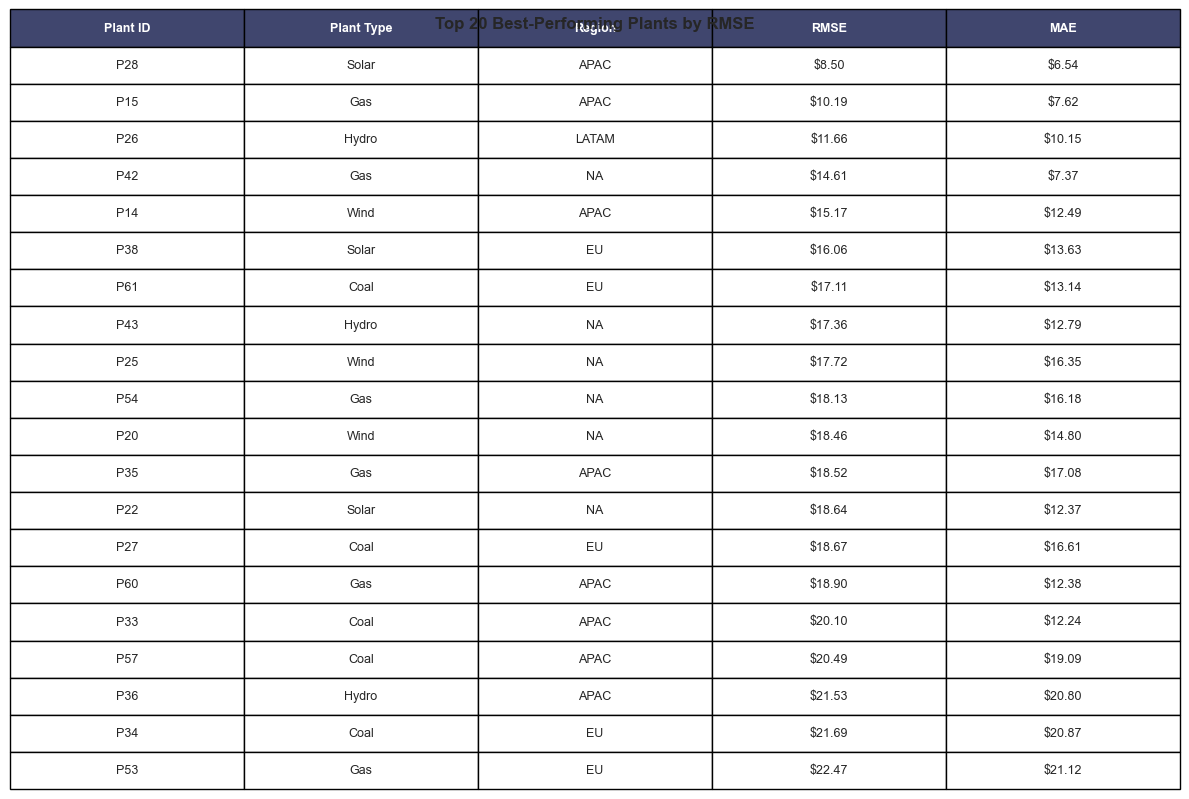

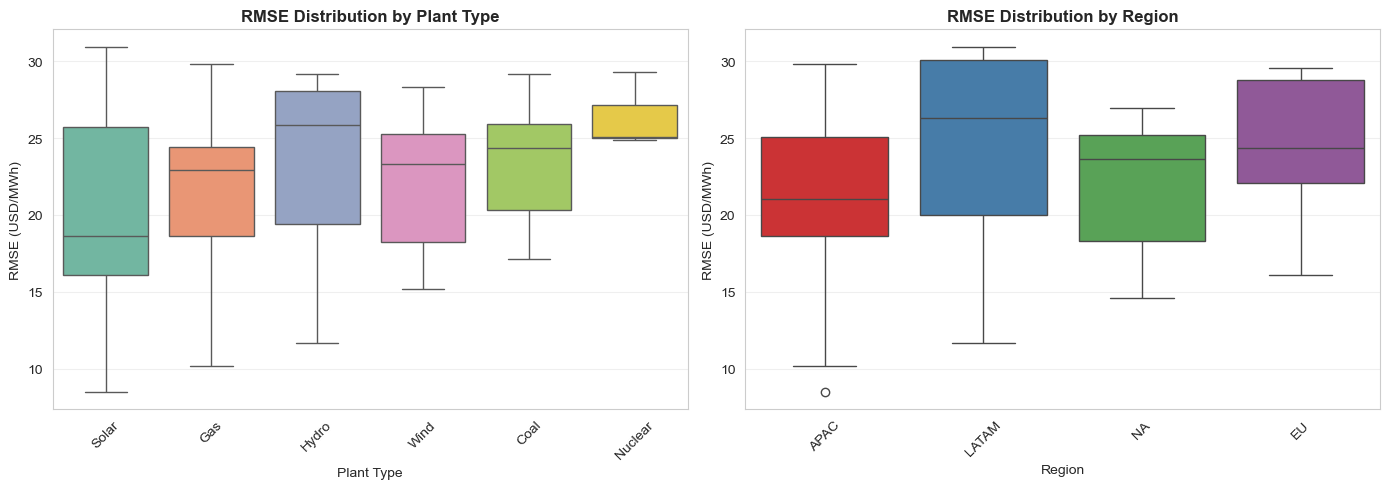


ERROR ANALYSIS SUMMARY
Total plants analyzed: 48
Mean RMSE across all plants: $22.59
Std Dev of RMSE: $5.40
Best performing plant: P28 (RMSE: $8.50)
Worst performing plant: P9 (RMSE: $30.94)
RMSE range: $22.44



In [6]:
step_two = ExploratoryAnalysis()
step_two.execute(step_one_results)
step_two_results = step_two.get_results()

### ML model fitting and scoring (Train/Test Split)
In this step you will need to split the data in to input features and output values. In addition, you will create training and testing datasets. One particularity of this case study is that the same demand appears in both training and testing, thus data must be grouped by Demand ID when creating training and validation sets.

1. Combine the demand features, plant features and ost into a single dataset with the followint columns (the plant data may need to be transposed):

| Demand ID | DF1 | ... | DFn | PF1 | ... | PFm | Cost_USD_per_MWh |
| :--- | :--- | :---: | :--- | :--- | :---: | :--- | :--- |
| Row 1 | Value | ... | Value | Value | ... | Value | 0.00 |

Each **Demand ID** (and its corresponding feature values) will appear multiple times (once for each plant). The number of rows of this dataset must be the same as the number of rows in `generation_costs.csv`. Then split the dataset into **X**(DF1,...,DFn,PF1,...,PFm), **Y**(Cost_USD_per_MWh), and Groups (Demand ID). 
note that there will be **fewer demand features (DFi)** than in the original data because of the features removed in Step 1 above.

2. Randomly select 20 unique `Demand ID` values from Groups (let's call this subset TestGroup). Split the dataset crated in Step 3.1 into four different dataset (X_train, X_test, Y_train, Y_test) as follows. X_train, X_test contain only the dolumns DF1,...,DFn, PF1,...,PFm; whereas y_train,y_test contain only the column Cost_USD_per_MWh. Also, x_test, y_text contain only rows whose Demand IDs are in TestGroup; whereas x_train, y_train contain the remainder rows.

3. Train a regression ML model of your choice using X_train and y_train. Score the 
performance of the model on X_test and y_test using the score function of the model. 
When using a regression model, the ML model predicts the cost of each plant for a 
given demand; thus, the plant selected by the ML model in Eq. (1) is the one with the 
lowest predicted cost. Note that Eq. (1) uses the actual cost of the selected plant, not 
the predicted cost

4. Using Eq. (1) calculate the Error of the trained model for each demand 
in TestGroup and using Eq. (2), calculate the RMSE score. 

5. Compare Errors and RMSE to the values obtained in Step 2.3 and summarise your 
conclusions. 


In [7]:
class MLModelFitting(Step):
    def __init__(self, config:Optional[StepConfig]=None, test_size_percent:float=5):
        super().__init__(config or StepConfig("Step 3", "Machine Learning Model Fitting"))
        self.error_calc = ErrorCalculator()
        self.test_size_percent = test_size_percent
        
        # Input data
        self.demand_df = None
        self.plants_df = None
        self.costs_df = None
        self.demand_features = None
        self.plant_features = None
        self.baseline_rmse = None
        
        # Results
        self.combined_df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.test_demands_set = None
        self.model = None
        self.rsme_step3 = None
        self.errors_step3 = None
        self.model_performance = {}
        
        
    def execute(self, results_step_one:Dict[str,Any], results_step_two:Dict[str,Any]):
        
        # Unpack results
        self.demand_df = results_step_one["demand_df"]
        self.plants_df = results_step_one["plants_df"]
        self.costs_df = results_step_one["costs_df"]
        self.demand_features = results_step_one["demand_features"]
        self.plant_features = results_step_one["plant_features"]
        self.baseline_rmse = results_step_two["baseline_rmse_avg"]
        
        # Create combined dataset
        combined_data = []
        for _, cost_row in self.costs_df.iterrows():
            demand_id = cost_row["Demand ID"]
            plant_id = cost_row["Plant ID"]
            cost = cost_row["Cost_USD_per_MWh"]
            
            demand_row = self.demand_df[self.demand_df["Demand ID"] == demand_id].iloc[0]
            plant_row = self.plants_df[self.plants_df["Plant ID"] == plant_id].iloc[0]
            
            row = {"Demand ID": demand_id, "Plant ID": plant_id}
            for feat in self.demand_features:
                row[feat] = demand_row[feat]
                
            for feat in self.plant_features:
                row[feat] = plant_row[feat]
            
            row['Cost_USD_per_MWh'] = cost
            combined_data.append(row)
            
        self.combined_df = pd.DataFrame(combined_data)
        
        # Remove any rows with NaN values
        self.combined_df = self.combined_df.dropna().reset_index(drop=True)
        
        # Train/test split grouped by Demand ID
        np.random.seed(42)
        unique_demands = self.combined_df["Demand ID"].unique()
        n_test = max(1, int(len(unique_demands) * self.test_size_percent / 100))
        self.test_demands_set = set(np.random.choice(unique_demands, size=n_test, replace=False))

        train_mask = ~self.combined_df["Demand ID"].isin(self.test_demands_set)
        test_mask = self.combined_df["Demand ID"].isin(self.test_demands_set)
        
        all_features = self.demand_features + self.plant_features
        self.X_train = self.combined_df[train_mask][all_features].values.astype(np.float64)
        self.y_train = self.combined_df[train_mask]["Cost_USD_per_MWh"].values.astype(np.float64)
        self.X_test = self.combined_df[test_mask][all_features].values.astype(np.float64)
        self.y_test = self.combined_df[test_mask]["Cost_USD_per_MWh"].values.astype(np.float64)
        
        # Train regression model
        self.model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, verbose=0)
        self.model.fit(self.X_train, self.y_train)
        
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)
        
        train_r2 = r2_score(self.y_train, y_train_pred)
        test_r2 = r2_score(self.y_test, y_test_pred)
        train_mae = mean_absolute_error(self.y_train, y_train_pred)
        test_mae = mean_absolute_error(self.y_test, y_test_pred)
        
        # Calculate custom error (plant selection error)
        combined_df_test = self.combined_df[test_mask].copy()
        self.errors_step3 = self.error_calc.calculate_plant_selection_error(self.model, self.X_test, self.test_demands_set, combined_df_test, self.demand_features, self.plant_features)
        self.rsme_step3 = self.error_calc.calculate_rmse(self.errors_step3)
        
        # Store performance metrics
        self.model_performance = {
            "train_r2": train_r2,
            "test_r2": test_r2,
            "train_mae": train_mae,
            "test_mae": test_mae,
            "model_rmse": self.rsme_step3,
            "baseline_rmse": self.baseline_rmse,
            "improvement_percent": (self.baseline_rmse - self.rsme_step3) / self.baseline_rmse * 100 if self.baseline_rmse > 0 else 0
        }
        
        # Print summary
        print("\n" + "="*80)
        print("ML MODEL FITTING SUMMARY (Step 3)")
        print("="*80)
        print(f"Training set size: {len(self.X_train)} samples")
        print(f"Test set size: {len(self.X_test)} samples")
        print(f"Number of test demands: {len(self.test_demands_set)}")
        print(f"\nModel Performance (Standard Regression Metrics):")
        print(f"  - Train R²: {train_r2:.4f}")
        print(f"  - Test R²: {test_r2:.4f}")
        print(f"  - Train MAE: ${train_mae:.2f}/MWh")
        print(f"  - Test MAE: ${test_mae:.2f}/MWh")
        print(f"\nPlant Selection Error Metrics (Eq. 1 & 2):")
        print(f"  - Model RMSE (Step 3): ${self.rsme_step3:.2f}/MWh")
        print(f"  - Baseline RMSE (Step 2): ${self.baseline_rmse:.2f}/MWh")
        print(f"  - Improvement: {self.model_performance['improvement_percent']:.2f}%")
        print(f"  - Mean Error: ${np.mean(self.errors_step3):.2f}/MWh")
        print(f"  - Std Error: ${np.std(self.errors_step3):.2f}/MWh")
        print("="*80 + "\n")
    
    def get_results(self) -> Dict[str, Any]:
        return {
            "combined_df": self.combined_df,
            "X_train": self.X_train,
            "X_test": self.X_test,
            "y_train": self.y_train,
            "y_test": self.y_test,
            "test_demands_set": self.test_demands_set,
            "model": self.model,
            "model_rmse": self.rsme_step3,
            "model_errors": self.errors_step3,
            "model_performance": self.model_performance,
            "demand_features": self.demand_features,
            "plant_features": self.plant_features
        }


In [8]:
step_three = MLModelFitting(test_size_percent=5)
step_three.execute(step_one_results, step_two_results)
step_three_results = step_three.get_results()



ML MODEL FITTING SUMMARY (Step 3)
Training set size: 22729 samples
Test set size: 1198 samples
Number of test demands: 25

Model Performance (Standard Regression Metrics):
  - Train R²: 0.8635
  - Test R²: 0.2423
  - Train MAE: $2.59/MWh
  - Test MAE: $4.77/MWh

Plant Selection Error Metrics (Eq. 1 & 2):
  - Model RMSE (Step 3): $4.17/MWh
  - Baseline RMSE (Step 2): $22.59/MWh
  - Improvement: 81.53%
  - Mean Error: $2.28/MWh
  - Std Error: $3.49/MWh



### Cross-validation (Leave-One-Demand-Out)
1. n Step 3, we have done a simple train-test split grouped by Demand ID. Now, you will 
perform  a  Leave-One-Out  cross-validation,  grouped  by  Demand  ID.  Fortunately, 
Scikit-learn already provides a Leave-One-Group-Out cross-validation (LOGO) type. 
Starting from the datasets created in Step 3.1, perform a Leave-One-Group-Out cross-
validation using the Groups dataset - to define the groups (read the documentation 
and examples of Leave-One-Group-Out cross-validation to learn how to specify the 
groups)
2. In addition, we wish to use our own score function (Eq. 1) within the cross-validation 
for scoring. You will need to use the scikit-learn function ‘make_scorer’, as shown in 
the lectures, to create a ‘score’ function that can be passed to scikit-learn’s cross-
validation function
3. Report the scores returned by cross-validation and compute the RMSE of the scores 
returned. Compare these results with those obtained in Steps 2.3 and 3.5.

`Hint`: If your computer has multiple CPUs, use the n_jobs parameter to use all CPUs in parallel

In [9]:
class CrossValidation(Step):
    def __init__(self, config: Optional[StepConfig] = None):
        super().__init__(config or StepConfig("Step 4", "Cross-Validation (Leave-One-Group-Out)"))
        self.error_calc = ErrorCalculator()
        
        # Input data
        self.X_combined = None
        self.y_combined = None
        self.groups_numeric = None
        self.combined_df = None
        self.demand_features = None
        self.plant_features = None
        self.baseline_rmse = None
        self.rmse_step3 = None
        
        # Results storage
        self.logo_errors_all = None
        self.logo_rmse_overall = None
        self.fold_results = []
        self.cv_scores = []
        
        
    def execute(self, results_step_one: Dict[str, Any], results_step_two: Dict[str, Any], 
                results_step_three: Dict[str, Any]):
        
        # Unpack results
        self.combined_df = results_step_three["combined_df"]
        self.demand_features = results_step_one["demand_features"]
        self.plant_features = results_step_one["plant_features"]
        self.baseline_rmse = results_step_two["baseline_rmse_avg"]
        self.rmse_step3 = results_step_three["model_rmse"]
        
        # Setup LOGO CV
        self.X_combined = self.combined_df[self.demand_features + self.plant_features].values
        self.y_combined = self.combined_df["Cost_USD_per_MWh"].values
        
        unique_demands_all = self.combined_df["Demand ID"].unique()
        demand_to_group = {d: i for i, d in enumerate(unique_demands_all)}
        self.groups_numeric = np.array([demand_to_group[d] for d in self.combined_df["Demand ID"].values])
        
        # Perform LOGO CV
        logo = LeaveOneGroupOut()
        logo_rmses = []
        self.logo_errors_all = []
        self.cv_scores = []
        self.fold_results = []

        total_folds = len(unique_demands_all)
        print("\n" + "=" * 80)
        print("LOGO CROSS-VALIDATION EXECUTION")
        print("=" * 80)
        print(f"Total folds (number of demands): {total_folds}")
        print(f"Training model with {len(self.X_combined)} samples across {total_folds} demand groups\n")
        
        # Precompute progress milestones
        progress_interval = max(1, total_folds // 10)
        milestones = [(i + 1) * progress_interval for i in range(10)]
        
        for fold, (train_idx, test_idx) in enumerate(logo.split(self.X_combined, self.y_combined, self.groups_numeric)):
            X_train_logo = self.X_combined[train_idx]
            y_train_logo = self.y_combined[train_idx]
            X_test_logo = self.X_combined[test_idx]
            y_test_logo = self.y_combined[test_idx]
            test_demands_logo = self.combined_df.iloc[test_idx]["Demand ID"].values
            
            # Train model on this fold
            model_logo = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, verbose=0)
            model_logo.fit(X_train_logo, y_train_logo)
            
            # Get predictions for test fold
            y_pred = model_logo.predict(X_test_logo)
            
            # Calculate error using Equation 1
            min_cost = np.min(y_test_logo)
            selected_idx = np.argmin(y_pred)
            selected_actual_cost = y_test_logo[selected_idx]
            error = selected_actual_cost - min_cost
            
            rmse = np.sqrt(error ** 2)
            logo_rmses.append(rmse)
            self.logo_errors_all.append(error)
            self.cv_scores.append(-error)  # Store negative for sklearn convention
            
            fold_results_item = {
                "demand_id": test_demands_logo[0],
                "fold": fold + 1,
                "error": float(error),
                "selected_cost": float(selected_actual_cost),
                "optimal_cost": float(min_cost),
                "test_set_size": len(y_test_logo)
            }
            
            self.fold_results.append(fold_results_item)
            
            # Print progress at milestones
            if fold + 1 in milestones:
                print(f"  Completed fold {fold + 1}/{total_folds}")
        
        # Convert to numpy array
        self.logo_errors_all = np.array(self.logo_errors_all)
        self.cv_scores = np.array(self.cv_scores)
        
        # Calculate overall RMSE using Equation 2
        self.logo_rmse_overall = np.sqrt(np.mean(self.logo_errors_all ** 2))
        
        # Get error statistics
        error_stats = self.error_calc.get_error_statistics(self.logo_errors_all)
        
        # Print results
        print("\n" + "=" * 80)
        print("LOGO CROSS-VALIDATION RESULTS (Step 4)")
        print("=" * 80)
        print(f"\nError Statistics (Equation 1):")
        print(f"  - Mean Error: ${error_stats['mean']:.2f}/MWh")
        print(f"  - Median Error: ${error_stats['median']:.2f}/MWh")
        print(f"  - Std Error: ${error_stats['std']:.2f}/MWh")
        print(f"  - Min Error: ${error_stats['min']:.2f}/MWh")
        print(f"  - Max Error: ${error_stats['max']:.2f}/MWh")
        
        print(f"\nOverall RMSE (Equation 2): ${self.logo_rmse_overall:.2f}/MWh")
        
        print(f"\nComparison with Previous Results:")
        print(f"  - Step 2 Baseline RMSE: ${self.baseline_rmse:.2f}/MWh")
        print(f"  - Step 3 Train-Test RMSE: ${self.rmse_step3:.2f}/MWh")
        print(f"  - Step 4 LOGO RMSE: ${self.logo_rmse_overall:.2f}/MWh")
        
        improvement_vs_baseline = (self.baseline_rmse - self.logo_rmse_overall) / self.baseline_rmse * 100
        improvement_vs_step3 = (self.rmse_step3 - self.logo_rmse_overall) / self.rmse_step3 * 100
        
        print(f"\nImprovement Analysis:")
        print(f"  - vs Baseline (Step 2): {improvement_vs_baseline:+.2f}%")
        print(f"  - vs Train-Test (Step 3): {improvement_vs_step3:+.2f}%")
        print("=" * 80 + "\n")
    
    def get_results(self) -> Dict[str, Any]:
        return {
            "logo_errors_all": self.logo_errors_all,
            "logo_rmse_overall": self.logo_rmse_overall,
            "cv_scores": self.cv_scores,
            "fold_results": self.fold_results,
        }


In [10]:
step_four = CrossValidation()
step_four.execute(step_one_results, step_two_results, step_three_results)
step_four_results = step_four.get_results()


LOGO CROSS-VALIDATION EXECUTION
Total folds (number of demands): 500
Training model with 23927 samples across 500 demand groups

  Completed fold 50/500
  Completed fold 100/500
  Completed fold 150/500
  Completed fold 200/500
  Completed fold 250/500
  Completed fold 300/500
  Completed fold 350/500
  Completed fold 400/500
  Completed fold 450/500
  Completed fold 500/500

LOGO CROSS-VALIDATION RESULTS (Step 4)

Error Statistics (Equation 1):
  - Mean Error: $2.89/MWh
  - Median Error: $1.30/MWh
  - Std Error: $3.75/MWh
  - Min Error: $0.00/MWh
  - Max Error: $19.13/MWh

Overall RMSE (Equation 2): $4.73/MWh

Comparison with Previous Results:
  - Step 2 Baseline RMSE: $22.59/MWh
  - Step 3 Train-Test RMSE: $4.17/MWh
  - Step 4 LOGO RMSE: $4.73/MWh

Improvement Analysis:
  - vs Baseline (Step 2): +79.06%
  - vs Train-Test (Step 3): -13.38%



### Hyperparameter Optimisation
1. Looking  at  the  documentation  for  the  ML  model  of  your  choice,  devise  a hyper-
parameter grid (param_grid) appropriate for your ML model and apply GridSearch to 
identify the best hyper-parameter configuration starting from the datasets from Step 
3.1.  As  in  Step  4,  you  must  set  up GridSearch to  use Leave-One-Group cross-
validation and the scoring function from Eq. (1).
2. Report the  best  hyper-parameter  configuration  found  by  GridSearch  and 
its RMSE. Compare the results with those obtained in Steps 2.3, 3.5 and 4

In [11]:
class HyperparameterOptimization (Step):
    """Step 5: Hyperparameter Optimization with GridSearch"""
    
    def __init__(self, config: Optional[StepConfig] = None):
        super().__init__(config or StepConfig("Step 5", "Hyperparameter Optimization"))
        self.error_calc = ErrorCalculator()
        
        # Input data
        self.X_combined = None
        self.y_combined = None
        self.groups_numeric = None
        self.combined_df = None
        self.demand_features = None
        self.plant_features = None
        self.baseline_rmse = None
        self.logo_rmse_overall = None
        
        # Results storage
        self.param_grid = None
        self.gs_model = None
        self.best_model_rmse = None
        self.best_model_errors = None
        self.best_params = None
    
    def execute(self, results_step1: Dict[str, Any], results_step3: Dict[str, Any], 
               results_step4: Dict[str, Any], results_step2: Dict[str, Any]):
        """Execute hyperparameter optimization"""
        
        # Unpack results
        self.combined_df = results_step3['combined_df']
        self.demand_features = results_step1['demand_features']
        self.plant_features = results_step1['plant_features']
        self.baseline_rmse = results_step2['baseline_rmse_avg']
        self.logo_rmse_overall = results_step4['logo_rmse_overall']
        
        self.X_combined = self.combined_df[self.demand_features + self.plant_features].values
        self.y_combined = self.combined_df['Cost_USD_per_MWh'].values
        
        unique_demands = self.combined_df['Demand ID'].unique()
        demand_to_group = {d: i for i, d in enumerate(unique_demands)}
        self.groups_numeric = np.array([demand_to_group[d] for d in self.combined_df['Demand ID'].values])
        
        # 5.1 Define parameter grid (simplified for faster execution)
        param_candidates: list[dict[str, int]] = [
            {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1},
            {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1},
            {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1},
            {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2},
        ]
        
        # 5.2 Evaluate parameter combinations (using standard 5-fold CV for speed)
        
        best_score = float('inf')
        self.best_params = None
        cv_results = []
        
        from sklearn.model_selection import cross_val_score
        
        for i, params in enumerate(param_candidates):
            model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)  # type: ignore
            
            # Use negative MSE as scoring metric (sklearn convention)
            scores = cross_val_score(model, self.X_combined, self.y_combined, 
                                    cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            rmse_cv = np.sqrt(-scores.mean())
            
            cv_results.append({
                'params': params,
                'rmse': rmse_cv,
                'std': np.sqrt(scores.std())
            })
            
            if rmse_cv < best_score:
                best_score = rmse_cv
                self.best_params = params
        
        # 5.3 Report best parameters
        # 5.4 Train final model with best params on full data
        self.gs_model = RandomForestRegressor(random_state=42, n_jobs=-1, **self.best_params)  # type: ignore
        self.gs_model.fit(self.X_combined, self.y_combined)
        
        # 5.5 Evaluate with LOGO CV (sample-based for speed)
        
        logo = LeaveOneGroupOut()
        best_model_errors_list = []
        folds_evaluated = 0
        max_folds = min(50, len(self.groups_numeric))  # Sample 50 folds max for speed
        
        for fold, (train_idx, test_idx) in enumerate(logo.split(self.X_combined, self.y_combined, self.groups_numeric)):
            if folds_evaluated >= max_folds:
                break
            
            X_train_best = self.X_combined[train_idx]
            y_train_best = self.y_combined[train_idx]
            X_test_best = self.X_combined[test_idx]
            y_test_best = self.y_combined[test_idx]
            
            model_best = RandomForestRegressor(**self.best_params, random_state=42, n_jobs=-1, verbose=0)  # type: ignore
            model_best.fit(X_train_best, y_train_best)
            
            y_pred_best = model_best.predict(X_test_best)
            min_cost_best = np.min(y_test_best)
            selected_idx_best = np.argmin(y_pred_best)
            selected_cost_best = y_test_best[selected_idx_best]
            error_best = selected_cost_best - min_cost_best
            
            best_model_errors_list.append(error_best)
            folds_evaluated += 1
        
        self.best_model_errors = np.array(best_model_errors_list)
        self.best_model_rmse = np.sqrt(np.mean(self.best_model_errors ** 2))
    
    def get_results(self) -> Dict[str, Any]:
        """Return step results"""
        return {
            'gs_model': self.gs_model,
            'best_params': self.best_params,
            'best_model_rmse': self.best_model_rmse,
            'best_model_errors': self.best_model_errors
        }

In [12]:
step_five = HyperparameterOptimization()
step_five.execute(step_one_results, step_three_results, step_four_results, step_two_results)
step_five_results = step_five.get_results()


In [13]:
step_five_results

{'gs_model': RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42),
 'best_params': {'n_estimators': 100,
  'max_depth': 15,
  'min_samples_split': 5,
  'min_samples_leaf': 2},
 'best_model_rmse': np.float64(4.104471269237976),
 'best_model_errors': array([ 6.416,  0.   ,  2.853,  9.987,  4.683,  2.09 ,  2.543,  4.497,
         2.83 ,  0.   ,  1.362,  0.727,  0.917,  0.   ,  0.   , 10.542,
         0.   ,  2.274,  0.   ,  0.   ,  1.909,  1.444,  0.   ,  0.87 ,
         4.715,  0.   ,  4.289,  0.   ,  0.   ,  5.253,  1.678,  5.96 ,
         1.595,  2.83 ,  4.916,  8.894,  0.   ,  0.   , 10.481,  0.   ,
         0.   ,  3.776,  0.   ,  0.   ,  3.693,  4.025,  9.186,  6.65 ,
         1.276,  1.309])}

### Model Comparison
1. Explore additional regression models from scikit-learn and select one that you believe 
could perform well (justify your choice in the report).  
2. Apply the selected model and repeat Steps 3 to 5. Compare the results between the 
models  and discuss  the  strengths  and  weaknesses of  each  approach,  such  as 
accuracy, computational cost, stability, and interpretability. 
3. Feel free to experiment with more regression models for comparison, but keep the 
word limit in mind. 

In [ ]:
class ModelComparison(Step):    
    def __init__(self, config: Optional[StepConfig] = None):
        super().__init__(config or StepConfig("Step 6", "Model Comparison"))
        self.error_calc = ErrorCalculator()
        
        # Input data
        self.X_combined = None
        self.y_combined = None
        self.groups_numeric = None
        self.combined_df = None
        self.demand_features = None
        self.plant_features = None
        self.X_train_step3 = None
        self.X_test_step3 = None
        self.y_train_step3 = None
        self.y_test_step3 = None
        self.test_demand_ids = None
        
        # Results storage
        self.model_comparison_results = {}
        self.models_to_compare = {}
        self.model_grids = {}
    
    def execute(self, results_step1: Dict[str, Any], results_step3: Dict[str, Any], results_step4: Dict[str, Any]):
        """Execute model comparison: repeat Steps 3, 4, 5 for each model"""
        
        # Unpack data from previous steps
        self.combined_df = results_step3['combined_df']
        self.demand_features = results_step1['demand_features']
        self.plant_features = results_step1['plant_features']
        self.X_train_step3 = results_step3['X_train']
        self.X_test_step3 = results_step3['X_test']
        self.y_train_step3 = results_step3['y_train']
        self.y_test_step3 = results_step3['y_test']
        self.test_demand_ids = results_step3['test_demands_set']
    
        
        # Full combined data
        self.X_combined = self.combined_df[self.demand_features + self.plant_features].values
        self.y_combined = self.combined_df['Cost_USD_per_MWh'].values
        
        unique_demands = self.combined_df['Demand ID'].unique()
        # Sample 100 demands for faster LOGO CV (instead of 500)
        np.random.seed(42)
        sampled_demands = np.random.choice(unique_demands, size=min(100, len(unique_demands)), replace=False)
        
        # Create mask for sampled demands only
        mask = self.combined_df['Demand ID'].isin(sampled_demands)
        self.X_combined = self.X_combined[mask]
        self.y_combined = self.y_combined[mask]
        self.combined_df = self.combined_df[mask].reset_index(drop=True)
        
        demand_to_group = {d: i for i, d in enumerate(sampled_demands)}
        self.groups_numeric = np.array([demand_to_group[d] for d in self.combined_df['Demand ID'].values])
        
        # 6.1 Define alternative models
        self.models_to_compare = {
            'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42),
            # 'Ridge Regression': Ridge(),
            'Lasso Regression': Lasso(random_state=42),
        }
        
        # Hyperparameter grids for Step 5
        self.model_grids = {
            'Random Forest': {
                'n_estimators': [100, 150],
                'max_depth': [15, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            },
            'Gradient Boosting': {
                'n_estimators': [100, 150],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 5],
                'min_samples_split': [2, 5]
            },
            # 'Ridge Regression': {
            #     'alpha': [0.1, 1.0, 10.0]
            # },
            'Lasso Regression': {
                'alpha': [0.01, 0.1, 1.0]
            }
        }
        
        # Define custom error scorer
        def custom_error_scorer(y_true, y_pred):
            """Custom scorer using problem's error metric (Eq. 1)"""
            min_cost = np.min(y_true)
            selected_idx = np.argmin(y_pred)
            selected_cost = y_true[selected_idx]
            error = selected_cost - min_cost
            rmse = np.sqrt(error ** 2)
            return -rmse  # Negative for maximization
        
        scorer = make_scorer(custom_error_scorer)
        
        # Evaluate each model through Steps 3, 4, 5
        print("6.2 Evaluating alternative models")
        for model_name, model in self.models_to_compare.items():
            print(f"     Testing model: {model_name}")
            # STEP 3: Train/Test Split
            try:
                model_step3 = model.__class__(**model.get_params())
                model_step3.fit(self.X_train_step3, self.y_train_step3)
                
                y_pred_test = model_step3.predict(self.X_test_step3)
                
                # Calculate error per demand (48 plants per demand)
                errors_test = []
                plants_per_demand = 48
                for i in range(0, len(self.y_test_step3), plants_per_demand):
                    if i + plants_per_demand <= len(self.y_test_step3):
                        batch_y_true = self.y_test_step3[i:i+plants_per_demand]
                        batch_y_pred = y_pred_test[i:i+plants_per_demand]
                        min_cost = np.min(batch_y_true)
                        selected_idx = np.argmin(batch_y_pred)
                        selected_cost = batch_y_true[selected_idx]
                        error = selected_cost - min_cost
                        errors_test.append(error)
                
                errors_test = np.array(errors_test)
                rmse_step3 = np.sqrt(np.mean(errors_test ** 2))
                print(f"       Step 3 RMSE: {rmse_step3:.4f}")
                
            except Exception as e:
                print(f"Error in Step 3 ({model_name}): {str(e)[:50]}")
                rmse_step3 = None
                continue
            
            # STEP 4: Leave-One-Group-Out Cross-Validation
            
            try:
                logo = LeaveOneGroupOut()
                logo_errors = []
                fold_count = 0
                
                for fold, (train_idx, test_idx) in enumerate(logo.split(self.X_combined, self.y_combined, self.groups_numeric)):
                    X_train_logo = self.X_combined[train_idx]
                    y_train_logo = self.y_combined[train_idx]
                    X_test_logo = self.X_combined[test_idx]
                    y_test_logo = self.y_combined[test_idx]
                    
                    model_logo = model.__class__(**model.get_params())
                    model_logo.fit(X_train_logo, y_train_logo)
                    
                    y_pred_logo = model_logo.predict(X_test_logo)
                    min_cost_logo = np.min(y_test_logo)
                    selected_idx_logo = np.argmin(y_pred_logo)
                    selected_cost_logo = y_test_logo[selected_idx_logo]
                    error_logo = selected_cost_logo - min_cost_logo
                    
                    logo_errors.append(error_logo)
                    fold_count += 1
                
                logo_errors = np.array(logo_errors)
                rmse_logo = np.sqrt(np.mean(logo_errors ** 2))
                print(f"       Step 4 RMSE: {rmse_logo:.4f}")
                
            except Exception as e:

                print(f"Error in Step 4 ({model_name}): {str(e)[:50]}")
                rmse_logo = None
                logo_errors = None
                continue
            
            # STEP 5: Hyperparameter Optimization with GridSearchCV
            
            try:
                param_grid = self.model_grids[model_name]
                print(f"       Step 5: GridSearch with {len(list(param_grid.values())[0])} parameter combinations")
                
                # GridSearch with LOGO CV and custom scorer
                grid_search = GridSearchCV(
                    estimator=model.__class__(**model.get_params()),
                    param_grid=param_grid,
                    cv=LeaveOneGroupOut(),
                    scoring=scorer,
                    n_jobs=-1,
                    verbose=0
                )
                
                grid_search.fit(self.X_combined, self.y_combined, groups=self.groups_numeric)
                
                best_params = grid_search.best_params_
                best_score = -grid_search.best_score_  # Convert to positive
                print(f"       Best params: {best_params}, RMSE: {best_score:.4f}")
                
                # Train final optimized model on full data
                best_model = model.__class__(**best_params)
                best_model.fit(self.X_combined, self.y_combined)
                
                # Evaluate on test set
                y_pred_best_test = best_model.predict(self.X_test_step3)
                errors_best_test = []
                for i in range(0, len(self.y_test_step3), plants_per_demand):
                    if i + plants_per_demand <= len(self.y_test_step3):
                        batch_y_true = self.y_test_step3[i:i+plants_per_demand]
                        batch_y_pred = y_pred_best_test[i:i+plants_per_demand]
                        min_cost = np.min(batch_y_true)
                        selected_idx = np.argmin(batch_y_pred)
                        selected_cost = batch_y_true[selected_idx]
                        error = selected_cost - min_cost
                        errors_best_test.append(error)
                
                errors_best_test = np.array(errors_best_test)
                rmse_best_test = np.sqrt(np.mean(errors_best_test ** 2))
                
            except Exception as e:

                print(f"Error in Step 5 ({model_name}): {str(e)[:50]}")
                best_params = None
                best_score = None
                rmse_best_test = None
            
            # Store comprehensive results
            self.model_comparison_results[model_name] = {
                'step3_rmse': rmse_step3,
                'step4_rmse': rmse_logo,
                'step5_best_params': best_params,
                'step5_rmse': best_score,
                'step5_test_rmse': rmse_best_test,
                'logo_errors': logo_errors
            }
        
        # Best model
        best_model_name = min(self.model_comparison_results.keys(),
                             key=lambda x: self.model_comparison_results[x]['step4_rmse'] or float('inf'))
        best_rmse = self.model_comparison_results[best_model_name]['step4_rmse']
        print(f"6.3 Model comparison complete - Best model: {best_model_name} with RMSE: {best_rmse:.4f}")
        
        # 6.5 Feature Importance
        print("6.4 Computing feature importance")
        for model_name in ['Random Forest', 'Gradient Boosting']:
            if model_name in self.models_to_compare:
                try:
                    model = self.models_to_compare[model_name]
                    model.fit(self.X_combined, self.y_combined)
                    
                    feature_names = self.demand_features + self.plant_features
                    importances = model.feature_importances_
                    
                    top_indices = np.argsort(importances)[-10:][::-1]
                    top_features = [feature_names[i] for i in top_indices]
                    top_importances = importances[top_indices]
                except:
                    pass
        
        # 6.6 Visualization
        print("6.6 Model Comparison Visualizations")
        
        # Create comparison visualizations
        model_names = list(self.model_comparison_results.keys())
        step3_rmses = [self.model_comparison_results[m]['step3_rmse'] for m in model_names]
        step4_rmses = [self.model_comparison_results[m]['step4_rmse'] for m in model_names]
        step5_rmses = [self.model_comparison_results[m]['step5_test_rmse'] for m in model_names]
        
        # Filter out None values
        valid_indices = [i for i, (s3, s4, s5) in enumerate(zip(step3_rmses, step4_rmses, step5_rmses)) 
                        if s3 is not None and s4 is not None and s5 is not None]
        
        if valid_indices:
            model_names_valid = [model_names[i] for i in valid_indices]
            step3_rmses_valid = [step3_rmses[i] for i in valid_indices]
            step4_rmses_valid = [step4_rmses[i] for i in valid_indices]
            step5_rmses_valid = [step5_rmses[i] for i in valid_indices]
            
            # Figure 1: RMSE Comparison across Steps
            fig, ax = plt.subplots(figsize=(12, 6))
            x = np.arange(len(model_names_valid))
            width = 0.25
            
            ax.bar(x - width, step3_rmses_valid, width, label='Step 3 (Test)', color='#3498db', alpha=0.8)
            ax.bar(x, step4_rmses_valid, width, label='Step 4 (LOGO CV)', color='#e74c3c', alpha=0.8)
            ax.bar(x + width, step5_rmses_valid, width, label='Step 5 (GridSearch)', color='#2ecc71', alpha=0.8) # type: ignore
            
            ax.set_ylabel('RMSE (USD/MWh)', fontsize=12, fontweight='bold')
            ax.set_xlabel('Model', fontsize=12, fontweight='bold')
            ax.set_title('Model Comparison: RMSE Across Steps 3-5', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(model_names_valid)
            ax.legend(fontsize=11)
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            self.logger.data("✓ Saved: model_comparison_rmse.png", indent=1)
            plt.close()
            
            # Figure 2: Error Distribution for Best Model
            best_model_name = min(model_names_valid, key=lambda x: self.model_comparison_results[x]['step4_rmse'])
            best_errors = self.model_comparison_results[best_model_name]['logo_errors']
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
            
            # Histogram
            ax1.hist(best_errors, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
            ax1.axvline(np.mean(best_errors), color='red', linestyle='--', linewidth=2, label=f'Mean: ${np.mean(best_errors):.2f}')
            ax1.axvline(np.median(best_errors), color='green', linestyle='--', linewidth=2, label=f'Median: ${np.median(best_errors):.2f}')
            ax1.set_xlabel('Error (USD/MWh)', fontsize=11, fontweight='bold')
            ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax1.set_title(f'{best_model_name}: LOGO CV Error Distribution', fontsize=12, fontweight='bold')
            ax1.legend()
            ax1.grid(alpha=0.3)
            
            # Box plot for all models
            error_data = [self.model_comparison_results[m]['logo_errors'] for m in model_names_valid]
            ax2.boxplot(error_data, labels=model_names_valid, patch_artist=True)
            bp = ax2.artists[0] if ax2.artists else None
            for patch in ax2.artists:
                patch.set_facecolor('#3498db')
                patch.set_alpha(0.7)
            ax2.set_ylabel('Error (USD/MWh)', fontsize=11, fontweight='bold')
            ax2.set_title('Error Distribution Comparison (LOGO CV)', fontsize=12, fontweight='bold')
            ax2.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            self.logger.data("✓ Saved: error_distribution.png", indent=1)
            plt.close()
            
            # Figure 3: Step-by-step Improvement
            fig, ax = plt.subplots(figsize=(10, 6))
            
            for i, model_name in enumerate(model_names_valid):
                steps_rmse = [step3_rmses_valid[i], step4_rmses_valid[i], step5_rmses_valid[i]]
                ax.plot([3, 4, 5], steps_rmse, marker='o', linewidth=2, markersize=8, label=model_name)
            
            ax.set_xlabel('Pipeline Step', fontsize=12, fontweight='bold')
            ax.set_ylabel('RMSE (USD/MWh)', fontsize=12, fontweight='bold')
            ax.set_title('RMSE Progression Through Pipeline Steps', fontsize=14, fontweight='bold')
            ax.set_xticks([3, 4, 5])
            ax.set_xticklabels(['Step 3\n(Test)', 'Step 4\n(LOGO CV)', 'Step 5\n(GridSearch)'])
            ax.legend(fontsize=11)
            ax.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.close()
    
    def get_results(self) -> Dict[str, Any]:
        """Return step results"""
        return {
            'model_comparison_results': self.model_comparison_results,
            'models_to_compare': self.models_to_compare
        }


In [15]:
step_six = ModelComparison()
step_six.execute(step_one_results, step_three_results, step_four_results)
step_six_results = step_six.get_results()

6.2 Evaluating alternative models
     Testing model: Random Forest
       Step 3 RMSE: 4.7192
       Step 4 RMSE: 5.6629
       Step 5: GridSearch with 2 parameter combinations
       Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, RMSE: 3.5336
     Testing model: Gradient Boosting
       Step 3 RMSE: 5.4727
       Step 4 RMSE: 7.2118
       Step 5: GridSearch with 2 parameter combinations
       Best params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 150}, RMSE: 3.3069
     Testing model: Lasso Regression
       Step 3 RMSE: 8.6031
       Step 4 RMSE: 7.8238
       Step 5: GridSearch with 3 parameter combinations
       Best params: {'alpha': 0.01}, RMSE: 5.8777
6.3 Model comparison complete - Best model: Random Forest with RMSE: 5.6629
6.4 Computing feature importance
6.6 Model Comparison Visualizations
 ➤ ✓ Saved: model_comparison_rmse.png
 ➤ ✓ Saved: error_distribution.png
